In [13]:
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tbparse import SummaryReader
from torch_ac.utils import DictList

In [21]:
def sorted_listdir(path):
    files = sorted((f for f in os.listdir(path) if not f.startswith(".")), key=str.lower)
    return files

def make_plots(ax, data, approach, color, start=0, title=None):
    label = 'ppo baseline' if approach == 'ppo' else approach
    x = data['step'][start:]
    median = data['rreturn_mean'][start:]
    # moving average over a window
    #median = median_raw.rolling(window=5).mean()
    std = data['rreturn_std'][start:]
    ax.plot(x, median, color=color, label=label, lw=1)
    ax.fill_between(x, median - std, median + std, color=color, alpha=0.1, lw=0)
    #ax.legend(loc="lower left")
    if title is not None:
        leg = ax.legend(title=title, loc="lower left", title_fontsize=12)
        ax.get_legend()._legend_box.align = "left"
    else:
        ax.legend(loc="lower left")


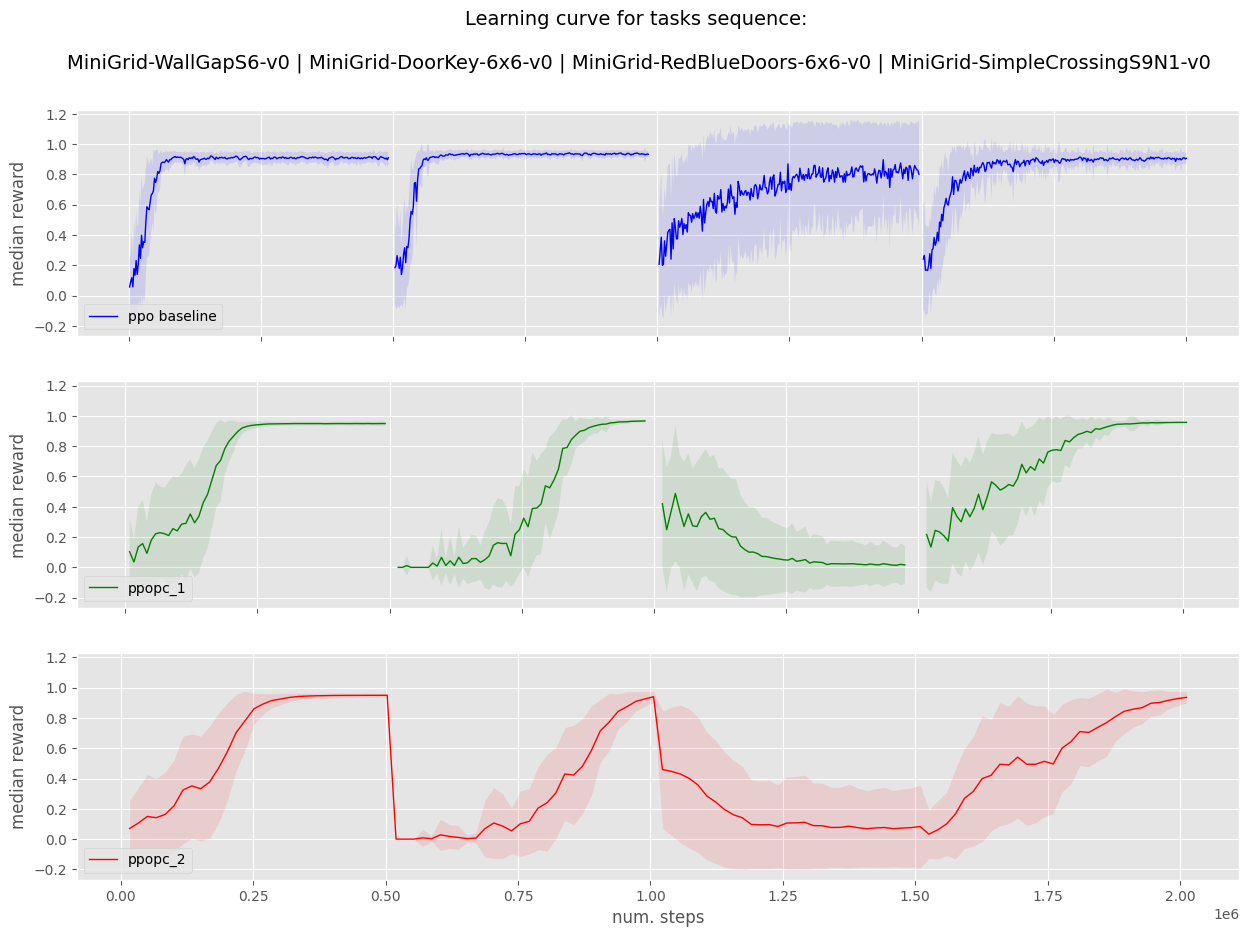

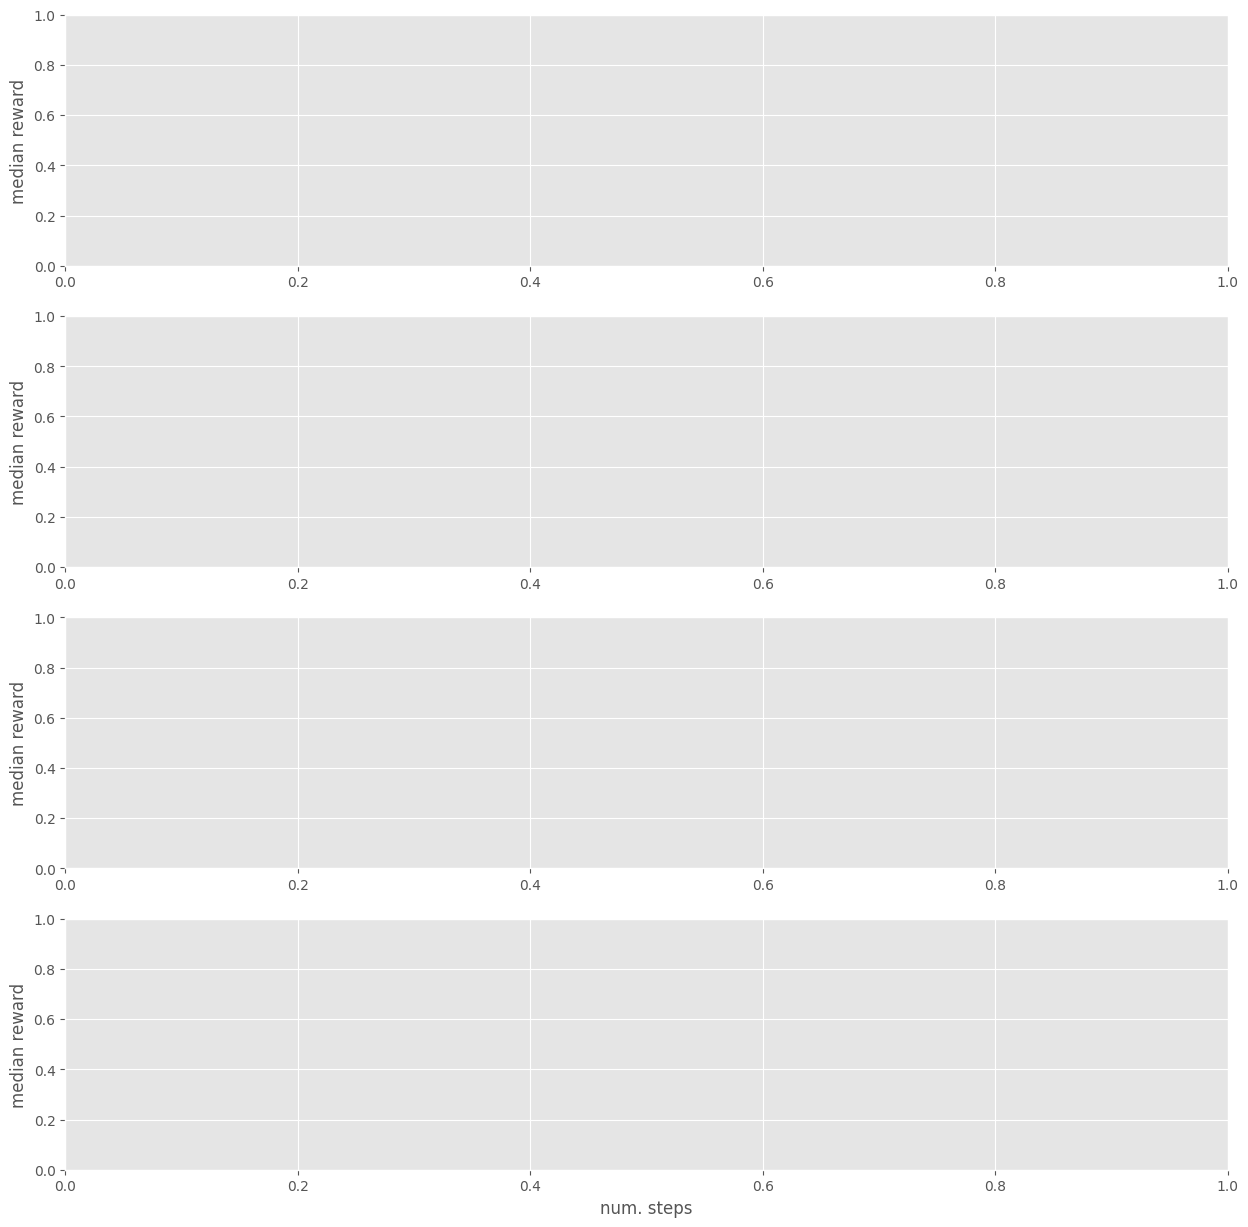

In [22]:
exp = 'minigrid-wallgap-doorkey-redbluedoor-crossing'

# Experiment details
experiments = [
    ('2023-11-11', exp, [
    (0, 'MiniGrid-WallGapS6-v0'),
    (1, 'MiniGrid-DoorKey-6x6-v0'),
    (2, 'MiniGrid-RedBlueDoors-6x6-v0'), 
    (3, 'MiniGrid-SimpleCrossingS9N1-v0')  
    ])    
    ]
    
args = {}
args = DictList(args)

episodes = 100
argmax = True # Deterministic for evaluation
task_state = None
metrics_dir = './metrics/'
procs = 16

date = "2023-11-11"
model = "wallgap-doorkey-redblue-crossing"

frames = 500000
frames_per_proc = 128
frames_per_proc_1 = 512
frames_per_proc_2 = 1048
cascade_depth = 4
reshape_reward_ppo = False
reshape_reward_ppopc = True

num_frames_list = []
fps_list = []
duration_list = []
return_per_episode_list = []
num_frames_per_episode_list = []


date = experiments[0][0]
experiment = experiments[0][1]
tasks_sequence = experiments[0][2]

steps = '500000'
approaches = ['ppo', 'ppopc_1', 'ppopc_2']
stage = 'train'
seeds = [123456, 789012, 345678]

results_dict = {}  
df_list = []

last_task_idx = tasks_sequence[-1][0]
results_dict['num_tasks'] = len(tasks_sequence)


sequence = ''
for task in tasks_sequence:
    if task[0] == len(tasks_sequence) - 1:
        sequence = sequence + task[1]
    else:
        sequence = sequence + task[1] + ' | '
results_dict['sequence'] = sequence
task_updates = 96 / len(tasks_sequence)

# Main plot settings
plt.style.use('ggplot')
#color = iter(plt.cm.Set2(np.linspace(0, 1, len(approaches))))
color = iter(['b','g','r'])
#color = iter(['b', 'g', 'r', 'y', 'm', 'c'])
fig_train, axs_train = plt.subplots(len(approaches), sharey=True, figsize=(15, 10))
fig_eval, axs_eval = plt.subplots(len(tasks_sequence), sharey=True, figsize=(15, 15))
#fig_eval, axs_eval = plt.subplots(2,2, sharey=True, figsize=(15, 15))

# Main plotting loop
for n, approach in enumerate(approaches):
    results_dict['approach'] = {approach:{}}
    # a diff. color for each approach
    c = next(color)
    results_dict['approach'][approach]['color'] = c
    for i, seed in enumerate(seeds):

        if approach == "ppopc_1":
            log_name = '{}_{}_{}_{}_{}_frames_{}_cascade_{}_reshape_{}'.format(date, model, "ppopc", seed, frames, frames_per_proc_1, cascade_depth, reshape_reward_ppopc)
        elif approach == "ppopc_2":
            log_name = '{}_{}_{}_{}_{}_frames_{}_cascade_{}_reshape_{}'.format(date, model, "ppopc", seed, frames, frames_per_proc_2, cascade_depth,  reshape_reward_ppopc)
        elif approach == "ppo":
            log_name = '{}_{}_{}_{}_{}_frames_{}_reshape_{}'.format(date, model, approach, seed, frames, frames_per_proc, reshape_reward_ppo)

        if i == 0:
            results_dict['approach'][approach][stage] = {}
            results_dict['approach'][approach][stage]['data'] = []

        train_dir = os.path.join("./storage/", log_name)
        event_file = os.path.join(train_dir, sorted_listdir(train_dir)[0])
        reader = SummaryReader(event_file, pivot=True)
        df = reader.scalars
        df['rreturn_mean'] = pd.to_numeric(df['rreturn_mean'], errors='coerce')
        df['rreturn_std'] = pd.to_numeric(df['rreturn_std'], errors='coerce')
        df_mean_std = df[['step', 'rreturn_mean', 'rreturn_std']]
        results_dict['approach'][approach][stage]['data'].append(df_mean_std)
        # Check if last seed data has been reached and process the data
        if seed == seeds[-1]:
            df_list = results_dict['approach'][approach][stage]['data']
            df_all = pd.concat(df_list)
            df_all_median = pd.concat(df_list).groupby(['step'])['rreturn_mean'].median().reset_index()
            df_merged = df_all_median.merge(df_all[['rreturn_mean','rreturn_std']].drop_duplicates('rreturn_mean'), how='left', on='rreturn_mean')
            results_dict['approach'][approach][stage]['merged'] = df_merged
            fig_train.suptitle('Learning curve for tasks sequence: '+'\n\n'+results_dict['sequence'], fontsize=14)
            ax = axs_train[n]
            start = 0
            make_plots(ax, df_merged, approach, c, start)

for ax in axs_train.flat:
    ax.set(xlabel='num. steps', ylabel='median reward')
    ax.label_outer()

for i, ax in enumerate(axs_eval.flat):
    ax.set(ylabel='median reward')
    if i == len(tasks_sequence)-1 :
        ax.set(xlabel='num. steps')
